In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from env import host, username, password

# Acquire (acquire.py) - Zillow
For the following, iterate through the steps you would take to create functions: Write the code to do the following in a jupyter notebook, test it, convert to functions, then create the file to house those functions.

You will have a zillow.ipynb file and a helper file for each section in the pipeline.

# acquire & summarize

# 1. 
Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.

- Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid.
- Only include properties with a transaction in 2017, and include only the last transaction for each properity (so no duplicate property ID's), along with zestimate error and date of transaction.
- Only include properties that include a latitude and longitude value.
Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

In [2]:
def get_db_url(db_name):

    '''
    Connect to the SQL database with credentials stored in env file.
    Function parameter is the name of the database to connect to.
    Returns url.
    '''
    
    # Creates the url and the function returns this url
    url = f'mysql+pymysql://{username}:{password}@{host}/{db_name}'
    return (url)

In [3]:
def get_home_data():

    '''
    Connect to SQL Database with url function called within this function.
    Checks if database is already saved to computer in csv file.
    If no file found, saves to a csv file and assigns database to df variable.
    If file found, just assigns database to df variable.
    Returns df variable holding the  Home Value database.
    Includes all 52 Columns.
    '''
    
    # data_name allows the function to work no matter what a user might have saved their file name as
    # First, we check if the data is already stored in the computer
    # First conditional runs if the data is not already stored in the computer
    if os.path.isfile('zillow_home.csv') == False:

        # Querry selects the whole predicstion_2017 table from the database
        sql_querry = '''
                        SELECT *
                        FROM properties_2017
                        JOIN (SELECT id, logerror, pid, tdate FROM predictions_2017 AS pred_2017
                        JOIN (SELECT parcelid AS pid, Max(transactiondate) AS tdate FROM predictions_2017 GROUP BY parcelid) AS sq1
                        ON (pred_2017.parcelid = sq1.pid AND pred_2017.transactiondate = sq1.tdate)) AS sq2
                        ON (properties_2017.parcelid = sq2.pid)
                        LEFT JOIN airconditioningtype USING (airconditioningtypeid)
                        LEFT JOIN architecturalstyletype USING (architecturalstyletypeid)
                        LEFT JOIN buildingclasstype USING (buildingclasstypeid)
                        LEFT JOIN heatingorsystemtype USING (heatingorsystemtypeid)
                        LEFT JOIN propertylandusetype USING (propertylandusetypeid)
                        LEFT JOIN storytype USING (storytypeid)
                        LEFT JOIN typeconstructiontype USING (typeconstructiontypeid)
                        LEFT JOIN unique_properties USING (parcelid)
                        WHERE latitude IS NOT NULL AND longitude IS NOT NULL;
                    '''

        # Connecting to the data base and using the query above to select the data
        # the pandas read_sql function reads the query into a DataFrame
        df = pd.read_sql(sql_querry, get_db_url('zillow'))

        # If any duplicates found, this removes them
        # df.columns.duplicated() returns a boolean array, True for a duplicate or False if it is unique up to that point
        # Use ~ to flip the booleans and return the df as any columns that are not duplicated
        # df.loc accesses a group of rows and columns by label(s) or a boolean array
        df = df.loc[:,~df.columns.duplicated()]
        df = df.drop('pid',axis=1)

        # The pandas to_csv function writes the data frame to a csv file
        # This allows data to be stored locally for quicker exploration and manipulation
        df.to_csv('zillow_home.csv')

    # This conditional runs if the data has already been saved as a csv (if the function has already been run on your computer)
    else:
        # Reads the csv saved from above, and assigns to the df variable
        df = pd.read_csv('zillow_home.csv', index_col=0)

    return df


In [4]:
df = get_home_data()

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (64) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
df.head().T

,0,1,2,3,4
parcelid,14297519,17052889,14186244,12177905,10887214
typeconstructiontypeid,NaN,NaN,NaN,NaN,NaN
storytypeid,NaN,NaN,NaN,NaN,NaN
propertylandusetypeid,261,261,261,261,266
heatingorsystemtypeid,NaN,NaN,NaN,2,2
...,...,...,...,...,...
buildingclassdesc,NaN,NaN,NaN,NaN,NaN
heatingorsystemdesc,NaN,NaN,NaN,Central,Central
propertylandusedesc,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Condominium
storydesc,NaN,NaN,NaN,NaN,NaN


In [6]:
df.columns

Index(['parcelid', 'typeconstructiontypeid', 'storytypeid',
       'propertylandusetypeid', 'heatingorsystemtypeid', 'buildingclasstypeid',
       'architecturalstyletypeid', 'airconditioningtypeid', 'id',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'latitude',
       'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum',
       'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr',
       'unitcnt', 'yardbuildingsqft17',

# 2.
Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

In [7]:
print('Dataframe shape:',df.shape)

Dataframe shape: (77381, 68)


In [8]:
for col in df.columns:
    if col != 'parcelid' and col != 'id':
        print('Column name:',col)
        print(df[col].value_counts())
        print('\n')

Column name: typeconstructiontypeid
6.0     219
4.0       1
13.0      1
10.0      1
Name: typeconstructiontypeid, dtype: int64


Column name: storytypeid
7.0    50
Name: storytypeid, dtype: int64


Column name: propertylandusetypeid
261.0    52320
266.0    19294
246.0     2009
269.0     1944
248.0      727
247.0      535
265.0      333
263.0       74
275.0       58
260.0       37
267.0       29
31.0        15
264.0        6
Name: propertylandusetypeid, dtype: int64


Column name: heatingorsystemtypeid
2.0     33550
7.0     14065
24.0      846
6.0       776
20.0      104
13.0       59
18.0       23
1.0        13
10.0        3
11.0        1
Name: heatingorsystemtypeid, dtype: int64


Column name: buildingclasstypeid
4.0    14
3.0     1
Name: buildingclasstypeid, dtype: int64


Column name: architecturalstyletypeid
7.0     172
8.0      19
21.0      7
2.0       5
3.0       3
Name: architecturalstyletypeid, dtype: int64


Column name: airconditioningtypeid
1.0     23133
13.0     1574
5.0   

2016.0    77381
Name: assessmentyear, dtype: int64


Column name: landtaxvaluedollarcnt
21299.0     97
22755.0     68
304575.0    65
203050.0    63
30210.0     63
            ..
737433.0     1
68034.0      1
868500.0     1
434249.0     1
114688.0     1
Name: landtaxvaluedollarcnt, Length: 51600, dtype: int64


Column name: taxamount
2418.22     8
3720.52     7
2217.31     5
1725.20     5
3815.22     5
           ..
5434.38     1
3716.17     1
7358.73     1
4654.70     1
10240.00    1
Name: taxamount, Length: 73825, dtype: int64


Column name: taxdelinquencyflag
Y    2886
Name: taxdelinquencyflag, dtype: int64


Column name: taxdelinquencyyear
15.0    1552
14.0     799
13.0     183
12.0     113
11.0      98
10.0      66
9.0       47
8.0       14
7.0       10
6.0        1
3.0        1
4.0        1
99.0       1
Name: taxdelinquencyyear, dtype: int64


Column name: censustractandblock
6.037137e+13    60
6.037277e+13    51
6.059032e+13    44
6.059063e+13    41
6.037920e+13    41
           

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,77381.0,1.300715e+07,3.481346e+06,1.071186e+07,1.153830e+07,1.253157e+07,1.421183e+07,1.676893e+08
typeconstructiontypeid,222.0,6.040541e+00,5.572847e-01,4.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,1.300000e+01
storytypeid,50.0,7.000000e+00,0.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00
propertylandusetypeid,77381.0,2.618263e+02,5.141199e+00,3.100000e+01,2.610000e+02,2.610000e+02,2.660000e+02,2.750000e+02
heatingorsystemtypeid,49440.0,3.920510e+00,3.592779e+00,1.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,2.400000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
architecturalstyletypeid,206.0,7.388350e+00,2.734542e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
airconditioningtypeid,24953.0,1.813289e+00,2.967894e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
id,77381.0,1.495139e+06,8.609071e+05,3.490000e+02,7.520700e+05,1.497932e+06,2.240535e+06,2.982274e+06
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77381 entries, 0 to 77380
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77381 non-null  int64  
 1   typeconstructiontypeid        222 non-null    float64
 2   storytypeid                   50 non-null     float64
 3   propertylandusetypeid         77381 non-null  float64
 4   heatingorsystemtypeid         49440 non-null  float64
 5   buildingclasstypeid           15 non-null     float64
 6   architecturalstyletypeid      206 non-null    float64
 7   airconditioningtypeid         24953 non-null  float64
 8   id                            77381 non-null  int64  
 9   basementsqft                  50 non-null     float64
 10  bathroomcnt                   77381 non-null  float64
 11  bedroomcnt                    77381 non-null  float64
 12  buildingqualitytypeid         49672 non-null  float64
 13  c

# 3.
Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

#### What we want:   

|  column name  |  column Nan count  |  % rows with Nan  |

In [11]:
for col in df.columns:
    print('Columns name:',col)
    print('Nan count:',df[col].isnull().sum())
    print('\n')

Columns name: parcelid
Nan count: 0


Columns name: typeconstructiontypeid
Nan count: 77159


Columns name: storytypeid
Nan count: 77331


Columns name: propertylandusetypeid
Nan count: 0


Columns name: heatingorsystemtypeid
Nan count: 27941


Columns name: buildingclasstypeid
Nan count: 77366


Columns name: architecturalstyletypeid
Nan count: 77175


Columns name: airconditioningtypeid
Nan count: 52428


Columns name: id
Nan count: 0


Columns name: basementsqft
Nan count: 77331


Columns name: bathroomcnt
Nan count: 0


Columns name: bedroomcnt
Nan count: 0


Columns name: buildingqualitytypeid
Nan count: 27709


Columns name: calculatedbathnbr
Nan count: 609


Columns name: decktypeid
Nan count: 76767


Columns name: finishedfloor1squarefeet
Nan count: 71358


Columns name: calculatedfinishedsquarefeet
Nan count: 196


Columns name: finishedsquarefeet12
Nan count: 3632


Columns name: finishedsquarefeet13
Nan count: 77340


Columns name: finishedsquarefeet15
Nan count: 74372


Col

In [12]:
total = df.shape[0]
for col in df.columns:
    nulls = df[col].isnull().sum()
    print('Columns name:',col)
    print('Nan percentage:', (nulls / total))
    print('\n')

Columns name: parcelid
Nan percentage: 0.0


Columns name: typeconstructiontypeid
Nan percentage: 0.997131078688567


Columns name: storytypeid
Nan percentage: 0.9993538465514791


Columns name: propertylandusetypeid
Nan percentage: 0.0


Columns name: heatingorsystemtypeid
Nan percentage: 0.36108347010247993


Columns name: buildingclasstypeid
Nan percentage: 0.9998061539654437


Columns name: architecturalstyletypeid
Nan percentage: 0.9973378477920937


Columns name: airconditioningtypeid
Nan percentage: 0.6775306599811323


Columns name: id
Nan percentage: 0.0


Columns name: basementsqft
Nan percentage: 0.9993538465514791


Columns name: bathroomcnt
Nan percentage: 0.0


Columns name: bedroomcnt
Nan percentage: 0.0


Columns name: buildingqualitytypeid
Nan percentage: 0.3580853181013427


Columns name: calculatedbathnbr
Nan percentage: 0.007870149002985228


Columns name: decktypeid
Nan percentage: 0.9920652356521626


Columns name: finishedfloor1squarefeet
Nan percentage: 0.922164

In [13]:
def null_counts(df):
    rows = df.shape[0]
    nulls = pd.DataFrame(df.isnull().sum())
    nulls.columns = ['null_count']
    nulls['null_percentage'] = (nulls / rows)
    return nulls

In [14]:
null = null_counts(df)
null

,null_count,null_percentage
parcelid,0,0.000000
typeconstructiontypeid,77159,0.997131
storytypeid,77331,0.999354
propertylandusetypeid,0,0.000000
heatingorsystemtypeid,27941,0.361083
...,...,...
buildingclassdesc,77366,0.999806
heatingorsystemdesc,27941,0.361083
propertylandusedesc,0,0.000000
storydesc,77331,0.999354


### What we can do with this information:
- remove columns with more than 25% missing
- remove columns with more than 10,000 null values

# Prepare
# 1. 
Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.

In [15]:
properties = pd.DataFrame(df.propertylandusedesc.value_counts())
properties['id'] = df.propertylandusetypeid.unique()
properties   

,propertylandusedesc,id
Single Family Residential,52320,261.0
Condominium,19294,266.0
"Duplex (2 Units, Any Combination)",2009,246.0
Planned Unit Development,1944,260.0
"Quadruplex (4 Units, Any Combination)",727,269.0
"Triplex (3 Units, Any Combination)",535,247.0
Cluster Home,333,248.0
Mobile Home,74,31.0
"Manufactured, Modular, Prefabricated Homes",58,265.0
Residential General,37,267.0


In [16]:
# properties to be considered as single-unit
single_unit_ids = [262,266,74,58,37,6]

df = df[(df['propertylandusetypeid'] == 262) | (df['propertylandusetypeid'] == 266) | (df['propertylandusetypeid'] == 74) | (df['propertylandusetypeid'] == 58) | (df['propertylandusetypeid'] == 37) | (df['propertylandusetypeid'] == 6)]

# 2. 
Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

The input:
- A dataframe
- A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).
- A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).  

The output:
- The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.
hint:
- Look up the dropna documentation.
- You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.
- Make use of inplace, i.e. inplace=True/False.

In [17]:
null

,null_count,null_percentage
parcelid,0,0.000000
typeconstructiontypeid,77159,0.997131
storytypeid,77331,0.999354
propertylandusetypeid,0,0.000000
heatingorsystemtypeid,27941,0.361083
...,...,...
buildingclassdesc,77366,0.999806
heatingorsystemdesc,27941,0.361083
propertylandusedesc,0,0.000000
storydesc,77331,0.999354


In [18]:
def remove_nulls(df, col_percent, row_percent):
    
    # removing columns, loops through columns in df
    for col in df.columns:
        
        # calculates percentage of nulls by column
        nulls = df[col].isnull().sum()
        rows = df.shape[0]
        percent = (nulls / rows)
        
        # if percentage greater than specified col_percent
        if percent >= col_percent:
            
            # drops the column
            df = df.drop(col, axis=1)
         
    # removing observations, loops through rows in df   
    for row in df.index:
        
        # calculates percentage of nulls by row
        nulls = df[df.index == [row]].isnull().sum().sum()
        cols = df.shape[1]
        percent = (nulls / cols)
        
        # if percentage greater than specified row_percent
        if percent > row_percent:
            
            #drops the row
            df = df.drop(df.index[row])
            
    return df

In [19]:
df = remove_nulls(df, .25, .50)

In [20]:
df.isnull().sum()

parcelid                          0
propertylandusetypeid             0
id                                0
bathroomcnt                       0
bedroomcnt                        0
calculatedbathnbr                72
calculatedfinishedsquarefeet     61
finishedsquarefeet12             73
fips                              0
fullbathcnt                      72
latitude                          0
longitude                         0
propertycountylandusecode         0
rawcensustractandblock            0
regionidcity                    299
regionidcounty                    0
regionidzip                      18
roomcnt                           0
yearbuilt                        62
structuretaxvaluedollarcnt        9
taxvaluedollarcnt                 0
assessmentyear                    0
landtaxvaluedollarcnt             0
taxamount                         1
censustractandblock             104
logerror                          0
tdate                             0
propertylandusedesc         

In [21]:
df.shape

(19294, 28)

# 3. 
Decide how to handle the remaining missing values:

- Fill with constant value.
- Impute with mean, median, mode.
- Drop row/column

In [28]:
for col in df.columns:
    df = df.fillna(df[col].value_counts().index[0])

In [29]:
df.shape

(19294, 28)

In [30]:
df.isnull().sum()

parcelid                        0
propertylandusetypeid           0
id                              0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
tdate                           0
propertylandusedesc             0
dtype: int64

# Zillow_Wrangle.py
Functions of the work above needed to acquire and prepare a new sample of data.

# Mall Customers

# 1. 
Acquire data from mall_customers.customers in mysql database.

In [32]:
def get_mall_data():

    '''
    Connect to SQL Database with url function called within this function.
    Checks if database is already saved to computer in csv file.
    If no file found, saves to a csv file and assigns database to df variable.
    If file found, just assigns database to df variable.
    Returns df variable holding the  Mall data.
    '''
    
    # data_name allows the function to work no matter what a user might have saved their file name as
    # First, we check if the data is already stored in the computer
    # First conditional runs if the data is not already stored in the computer
    if os.path.isfile('mall_customers.csv') == False:

        # Querry selects the whole predicstion_2017 table from the database
        sql_querry = '''
                        SELECT *
                        FROM customers;
                    '''

        # Connecting to the data base and using the query above to select the data
        # the pandas read_sql function reads the query into a DataFrame
        df = pd.read_sql(sql_querry, get_db_url('mall_customers'))

        # If any duplicates found, this removes them
        # df.columns.duplicated() returns a boolean array, True for a duplicate or False if it is unique up to that point
        # Use ~ to flip the booleans and return the df as any columns that are not duplicated
        # df.loc accesses a group of rows and columns by label(s) or a boolean array
        df = df.loc[:,~df.columns.duplicated()]

        # The pandas to_csv function writes the data frame to a csv file
        # This allows data to be stored locally for quicker exploration and manipulation
        df.to_csv('mall_customers.csv')

    # This conditional runs if the data has already been saved as a csv (if the function has already been run on your computer)
    else:
        # Reads the csv saved from above, and assigns to the df variable
        df = pd.read_csv('mall_customers.csv', index_col=0)

    return df


In [34]:
df2 = get_mall_data()

In [37]:
df2.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# 2. 
Summarize data (include distributions and descriptive statistics).

In [35]:
df2.describe()

,customer_id,age,annual_income,spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


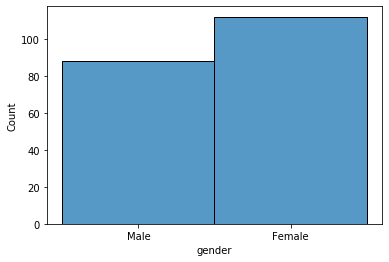

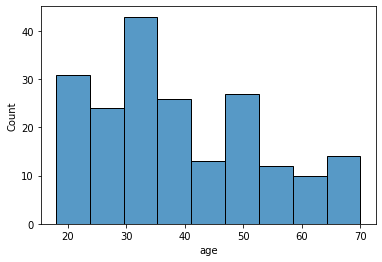

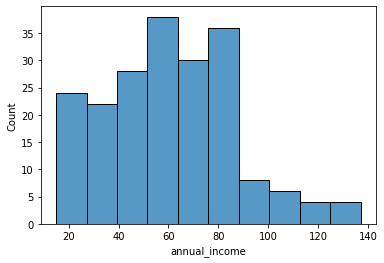

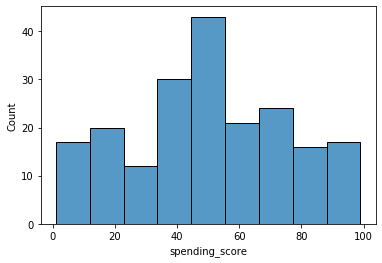

In [60]:
for col in df2.columns:
    if col == 'customer_id':
        pass
    else:
        sns.histplot(df2[col])
        plt.show()

# 3. 
Detect outliers using IQR.

In [72]:
# age, income, spending score
for col in df2.describe().columns:
    q1, q2, q3 = df2[col].quantile([0.25,0.5,0.75])
    IQR = q3 - q1
    
    upper = q3 + (1.5 * IQR)
    lower = q1 - (1.5 * IQR)
    
    print(upper, lower)

299.5 -98.5
79.375 -1.625
132.75 -13.25
130.375 -22.625


# 4. 
Split data (train, validate, and test split).

# 5. 
Encode categorical columns using a one hot encoder.

# 6. 
Handles missing values.

# 7. 
Scaling

# wrangle_mall.py

# 1. 
Acquire data from mall_customers.customers in mysql database.

# 2. 
Split the data into train, validate, and split

# 3.
One-hot-encoding

# 4.
Missing values

# 5.
Scaling